In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import random
import pyepo
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
# fix random seed
random.seed(135)
np.random.seed(135)
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Load Data

We use the Warcraft terrains shortest paths [dateset](https://edmond.mpdl.mpg.de/dataset.xhtml?persistentId=doi:10.17617/3.YJCQ5S). Datasets were randomly generated from the Warcraft II [tileset](http://github.com/war2/war2edit) and used in Vlastelica, Marin, et al. "Differentiation of Blackbox Combinatorial Solvers".

In [3]:
# map size
k = 12

### Maps 

In [4]:
tmaps_train = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/train_maps.npy".format(k,k))
#tmaps_val = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/val_maps.npy".format(k,k))
tmaps_test = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/test_maps.npy".format(k,k))

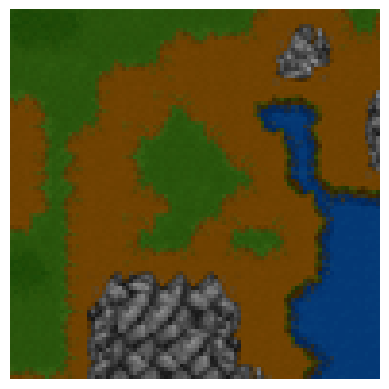

In [5]:
plt.axis("off")
plt.imshow(tmaps_train[0])
plt.show()

### Costs 

In [6]:
costs_train = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/train_vertex_weights.npy".format(k,k))
#costs_val = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/val_vertex_weights.npy".format(k,k))
costs_test = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/test_vertex_weights.npy".format(k,k))

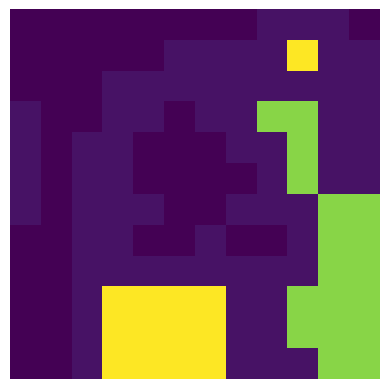

In [7]:
plt.axis("off")
plt.imshow(costs_train[0])
plt.show()

### Paths 

In [8]:
paths_train = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/train_shortest_paths.npy".format(k,k))
#paths_val = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/val_shortest_paths.npy".format(k,k))
paths_test = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/test_shortest_paths.npy".format(k,k))

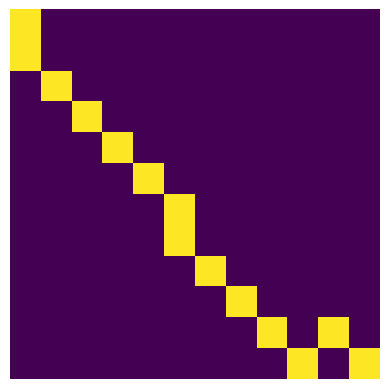

In [9]:
plt.axis("off")
plt.imshow(paths_train[0])
plt.show()

## Data Loader 

In [10]:
from torch.utils.data import Dataset
class mapDataset(Dataset):
    def __init__(self, tmaps, costs, paths):
        self.tmaps = tmaps
        self.costs = costs
        self.paths = paths
        self.objs = (costs * paths).sum(axis=(1,2)).reshape(-1,1)
        
    def __len__(self):
        return len(self.costs)
    
    def __getitem__(self, ind):
        return (
            torch.FloatTensor(self.tmaps[ind].transpose(2, 0, 1)/255).detach(), # image
            torch.FloatTensor(self.costs[ind]).reshape(-1),
            torch.FloatTensor(self.paths[ind]).reshape(-1),
            torch.FloatTensor(self.objs[ind]),
        )

In [11]:
# datasets
dataset_train = mapDataset(tmaps_train, costs_train, paths_train)
#dataset_val = mapDataset(tmaps_val, costs_val, paths_val)
dataset_test = mapDataset(tmaps_test, costs_test, paths_test)

In [12]:
# dataloader
from torch.utils.data import DataLoader
batch_size = 70
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
#loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Neural Network: Part of Resnet18 with Max Pooling

In [13]:
from torchvision.models import resnet18
nnet = resnet18(pretrained=False)
print(nnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# build new ResNet18 with Max Pooling
class partialResNet(nn.Module):
    
    def __init__(self, k):
        super(partialResNet, self).__init__()
        # init resnet 18
        resnet = resnet18(pretrained=False)
        # first five layers of ResNet18
        self.conv1 = resnet.conv1
        self.bn = resnet.bn1
        self.relu = resnet.relu
        self.maxpool1 = resnet.maxpool
        self.block = resnet.layer1
        # conv to 1 channel
        self.conv2  = nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
        # max pooling
        self.maxpool2 = nn.AdaptiveMaxPool2d((k,k))
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.bn(h)
        h = self.relu(h)
        h = self.maxpool1(h)
        h = self.block(h)
        h = self.conv2(h)
        out = self.maxpool2(h)
        # reshape for optmodel
        out = torch.squeeze(out, 1)
        out = out.reshape(out.shape[0], -1)
        return out

## Optimization Model: Linear Programming 

In [15]:
import gurobipy as gp
from gurobipy import GRB

from pyepo.model.grb.grbmodel import optGrbModel

class shortestPathModel(optGrbModel):
    """
    This class is optimization model for shortest path problem on 2D grid with 8 neighbors

    Attributes:
        _model (GurobiPy model): Gurobi model
        grid (tuple of int): Size of grid network
        nodes (list): list of vertex
        edges (list): List of arcs
        nodes_map (ndarray): 2D array for node index
    """

    def __init__(self, grid):
        """
        Args:
            grid (tuple of int): size of grid network
        """
        self.grid = grid
        self.nodes, self.edges, self.nodes_map = self._getEdges()
        super().__init__()

    def _getEdges(self):
        """
        A method to get list of edges for grid network

        Returns:
            list: arcs
        """
        # init list
        nodes, edges = [], []
        # init map from coord to ind
        nodes_map = {}
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                u = self._calNode(i, j)
                nodes_map[u] = (i,j)
                nodes.append(u)
                # edge to 8 neighbors
                # up
                if i != 0:
                    v = self._calNode(i-1, j)
                    edges.append((u,v))
                    # up-right
                    if j != self.grid[1] - 1:
                        v = self._calNode(i-1, j+1)
                        edges.append((u,v))
                # right
                if j != self.grid[1] - 1:
                    v = self._calNode(i, j+1)
                    edges.append((u,v))
                    # down-right
                    if i != self.grid[0] - 1:
                        v = self._calNode(i+1, j+1)
                        edges.append((u,v))
                # down
                if i != self.grid[0] - 1:
                    v = self._calNode(i+1, j)
                    edges.append((u,v))
                    # down-left
                    if j != 0:
                        v = self._calNode(i+1, j-1)
                        edges.append((u,v))
                # left
                if j != 0:
                    v = self._calNode(i, j-1)
                    edges.append((u,v))
                    # top-left
                    if i != 0:
                        v = self._calNode(i-1, j-1)
                        edges.append((u,v))
        return nodes, edges, nodes_map
    
    def _calNode(self, x, y):
        """
        A method to calculate index of node
        """
        v = x * self.grid[1] + y
        return v

    def _getModel(self):
        """
        A method to build Gurobi model

        Returns:
            tuple: optimization model and variables
        """
        # ceate a model
        m = gp.Model("shortest path")
        # varibles
        x = m.addVars(self.edges, ub=1, name="x")
        # sense
        m.modelSense = GRB.MINIMIZE
        # constraints
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                v = self._calNode(i, j)
                expr = 0
                for e in self.edges:
                    # flow in
                    if v == e[1]:
                        expr += x[e]
                    # flow out
                    elif v == e[0]:
                        expr -= x[e]
                # source
                if i == 0 and j == 0:
                    m.addConstr(expr == -1)
                # sink
                elif i == self.grid[0] - 1 and j == self.grid[0] - 1:
                    m.addConstr(expr == 1)
                # transition
                else:
                    m.addConstr(expr == 0)
        return m, x
    
    def setObj(self, c):
        """
        A method to set objective function

        Args:
            c (np.ndarray): cost of objective function
        """
        # vector to matrix
        c = c.reshape(self.grid)
        # sum up vector cost
        obj = c[0,0] + gp.quicksum(c[self.nodes_map[j]] * self.x[i,j] for i, j in self.x)
        self._model.setObjective(obj)
        
    def solve(self):
        """
        A method to solve model

        Returns:
            tuple: optimal solution (list) and objective value (float)
        """
        # update gurobi model
        self._model.update()
        # solve
        self._model.optimize()
        # kxk solution map
        sol = np.zeros(self.grid)
        for i, j in self.edges:
            # active edge
            if abs(1 - self.x[i,j].x) < 1e-3:
                # node on active edge
                sol[self.nodes_map[i]] = 1
                sol[self.nodes_map[j]] = 1
        # matrix to vector
        sol = sol.reshape(-1)
        return sol, self._model.objVal

In [16]:
# init model
grid = (k, k)
optmodel = shortestPathModel(grid)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-09


Obj: 26.998046875
Path:


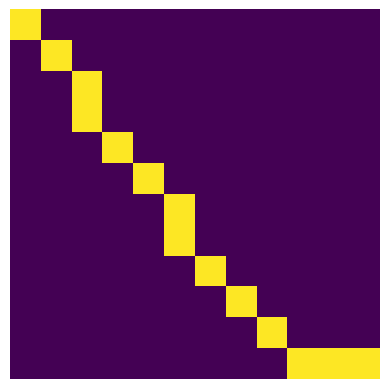

In [17]:
# test
optmodel.setObj(costs_train[0]) # assign cost
sol, obj = optmodel.solve() # solve
print("Obj: {}".format(obj))
print("Path:")
plt.axis("off")
plt.imshow(sol.reshape(k,k))
plt.show()

## Functions 

In [18]:
class earlyStopper:
    """
    Early stopping for training
    """
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.min_regret = np.inf

    def stop(self, regret):
        if regret + 1e-5 < self.min_regret:
            self.min_regret = regret
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [19]:
def evaluate(nnet, optmodel, dataloader):
    # init data
    data = {"Regret":[], "Relative Regret":[], "Accuracy":[], "Optimal":[]}
    # eval
    nnet.eval()
    for x, c, w, z in tqdm(dataloader):
        # cuda
        if next(nnet.parameters()).is_cuda:
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # predict
        cp = nnet(x)
        # to numpy
        c = c.to("cpu").detach().numpy()
        w = w.to("cpu").detach().numpy()
        z = z.to("cpu").detach().numpy()
        cp = cp.to("cpu").detach().numpy()
        # solve
        for i in range(cp.shape[0]):
            # sol for pred cost
            optmodel.setObj(cp[i])
            wpi, _ = optmodel.solve()
            # obj with true cost
            zpi = np.dot(wpi, c[i])
            # round
            zpi = zpi.round(1)
            zi = z[i,0].round(1)
            # regret
            regret = (zpi - zi).round(1)
            data["Regret"].append(regret)
            data["Relative Regret"].append(regret / zi)
            # accuracy
            data["Accuracy"].append((abs(wpi - w[i]) < 0.5).mean())
            # optimal
            data["Optimal"].append(abs(regret) < 1e-5)
    # dataframe
    df = pd.DataFrame.from_dict(data)
    # print
    time.sleep(1)
    print("Avg Regret: {:.4f}".format(df["Regret"].mean()))
    print("Avg Rel Regret: {:.2f}%".format(df["Relative Regret"].mean()*100))
    print("Path Accuracy: {:.2f}%".format(df["Accuracy"].mean()*100))
    print("Optimality Ratio: {:.2f}%".format(df["Optimal"].mean()*100))
    return df

In [20]:
def plotLearningCurve(loss_log, regret_log):
    # draw loss during training
    plt.figure(figsize=(8, 4))
    plt.plot(loss_log, color="c")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(-100, len(loss_log)+100)
    plt.xlabel("Iters", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.title("Learning Curve on Training Set", fontsize=16)
    plt.show()
    # draw normalized regret on test
    plt.figure(figsize=(8, 4))
    plt.plot([i*log_step for i in range(len(regret_log))], regret_log, color="royalblue")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(-epoch//50, epochs)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Normalized Regret", fontsize=16)
    plt.title("Learning Curve on Test Set", fontsize=16)
    plt.show()

## Hyperparameters 

In [21]:
# number of epochs
epochs = 50
# learning rate
lr = 5e-4
# log step
log_step = 1

## Two-Stage 

Two-Stage model: training with MSE of costs

In [22]:
# init net
nnet = partialResNet(k=12)
# cuda
if torch.cuda.is_available():
    nnet = nnet.cuda()
# set optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=lr)
# set stopper
# stopper = earlyStopper(patience=7)

In [23]:
# set loss
mseloss = nn.MSELoss()

In [24]:
# train
nnet.train()
loss_log1, regret_log1 = [], []
tbar = tqdm(range(epochs))
for epoch in tbar:
    for x, c, w, z in loader_train:
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = nnet(x) # predicted cost
        loss = mseloss(cp, c) # loss
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log1.append(loss.item())
        tbar.set_description("Epoch: {:2}, Loss: {:3.4f}".format(epoch, loss.item()))
    # scheduled learning rate
    if (epoch == int(epochs*0.6)) or (epoch == int(epochs*0.8)):
        for g in optimizer.param_groups:
            g['lr'] /= 10
    if epoch % log_step == 0:
        # log regret
        regret = pyepo.metric.regret(nnet, optmodel, loader_test) # regret on test
        regret_log1.append(regret)
        # early stop
        #regret = pyepo.metric.regret(nnet, optmodel, loader_val) # regret on val
        #if stopper.stop(regret):
        #    break

Epoch: 49, Loss: 0.4205: 100%|██████████████████████████████████████████████████████████████████████████| 50/50 [24:19<00:00, 29.19s/it]


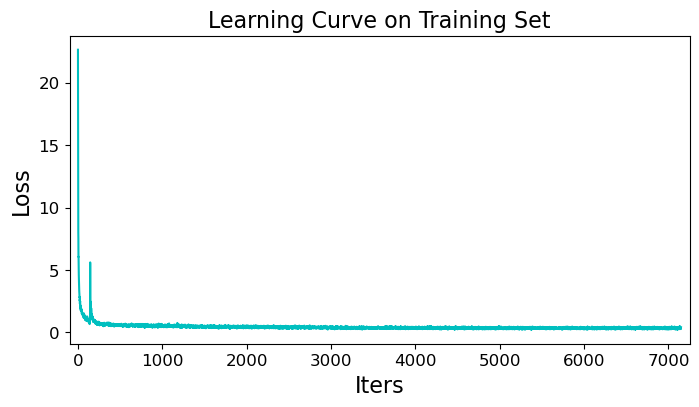

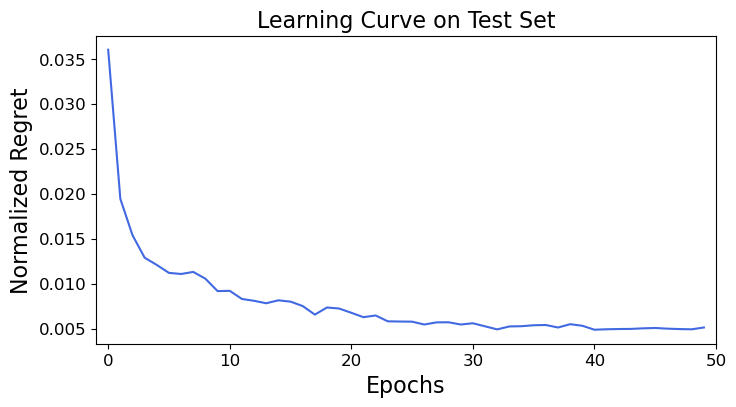

Test set:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.80s/it]


Avg Regret: 0.1520
Avg Rel Regret: 0.73%
Path Accuracy: 94.71%
Optimality Ratio: 82.30%


In [25]:
# plot    
plotLearningCurve(loss_log1, regret_log1)
# eval 
print("Test set:")
df1 = evaluate(nnet, optmodel, loader_test)

## Baseline 

Baseline model: training with binary cross entropy loss of solutions

In [26]:
# init net
nnet = partialResNet(k=12)
# cuda
if torch.cuda.is_available():
    nnet = nnet.cuda()
# set optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=lr)

In [27]:
# set loss
mseloss = nn.BCELoss()

In [28]:
# train
nnet.train()
loss_log2 = []
tbar = tqdm(range(150))
for epoch in tbar:
    for x, c, w, z in loader_train:
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        h = nnet(x)
        wp = torch.sigmoid(h)
        loss = mseloss(wp, w) # loss
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log2.append(loss.item())
        tbar.set_description("Epoch: {:2}, Loss: {:3.4f}".format(epoch, loss.item()))
    # scheduled learning rate
    if (epoch == 90) or (epoch == 120):
        for g in optimizer.param_groups:
            g['lr'] /= 10

Epoch: 149, Loss: 0.2640: 100%|███████████████████████████████████████████████████████████████████████| 150/150 [11:36<00:00,  4.64s/it]


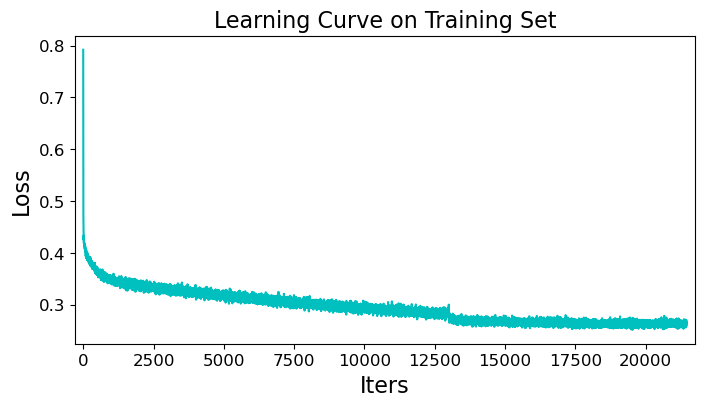

In [29]:
# draw loss during training
plt.figure(figsize=(8, 4))
plt.plot(loss_log2, color="c")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-300, len(loss_log2)+300)
plt.xlabel("Iters", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Learning Curve on Training Set", fontsize=16)
plt.show()

In [30]:
print("Test set:")
# init data
data = {"Accuracy":[], "Optimal":[]}
# eval
nnet.eval()
for x, c, w, z in tqdm(loader_test):
    # cuda
    if next(nnet.parameters()).is_cuda:
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = nnet(x)
    # to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    # solve
    for i in range(cp.shape[0]):
        # sol for pred cost
        optmodel.setObj(cp[i])
        wpi, _ = optmodel.solve()
        # obj with true cost
        zpi = np.dot(wpi, c[i])
        # round
        zpi = zpi.round(1)
        zi = z[i,0].round(1)
        # regret
        regret = (zpi - zi).round(1)
        # accuracy
        data["Accuracy"].append((abs(wpi - w[i]) < 0.5).mean())
        # optimal
        data["Optimal"].append(abs(regret) < 1e-2)
# dataframe
df2 = pd.DataFrame.from_dict(data)
# print
time.sleep(1)
print("Path Accuracy: {:.2f}%".format(df2["Accuracy"].mean()*100))
print("Optimality Ratio: {:.2f}%".format(df2["Optimal"].mean()*100))

Test set:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.86s/it]


Path Accuracy: 10.59%
Optimality Ratio: 0.00%


## SPO+ 

SPO+ model: training with smart predict-then-optimize+ loss

In [31]:
# init net
nnet = partialResNet(k=12)
# cuda
if torch.cuda.is_available():
    nnet = nnet.cuda()
# set optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=lr)
# set stopper
#stopper = earlyStopper(patience=7)

In [32]:
# set loss
spoploss = pyepo.func.SPOPlus(optmodel, processes=1)

Num of cores: 1


In [33]:
# train
nnet.train()
loss_log3, regret_log3 = [], []
tbar = tqdm(range(epochs))
for epoch in tbar:
    for x, c, w, z in loader_train:
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = nnet(x) # predicted cost
        loss = spoploss(cp, c, w, z).mean() # loss
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log loss
        loss_log3.append(loss.item())
        tbar.set_description("Epoch: {:2}, Loss: {:3.4f}".format(epoch, loss.item()))
    # scheduled learning rate
    if (epoch == int(epochs*0.6)) or (epoch == int(epochs*0.8)):
        for g in optimizer.param_groups:
            g['lr'] /= 10
    if epoch % log_step == 0:
        # log regret
        regret = pyepo.metric.regret(nnet, optmodel, loader_test) # regret on test
        regret_log3.append(regret)
        # early stop
        #regret = pyepo.metric.regret(nnet, optmodel, loader_val) # regret on val
        #if stopper.stop(regret):
        #    break

Epoch: 49, Loss: 0.7591: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [3:47:39<00:00, 273.20s/it]


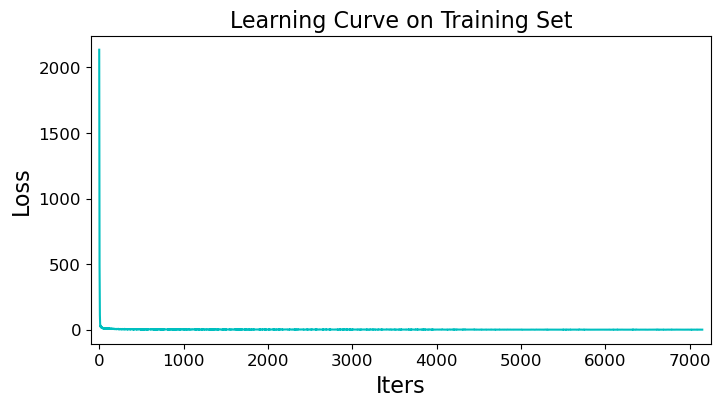

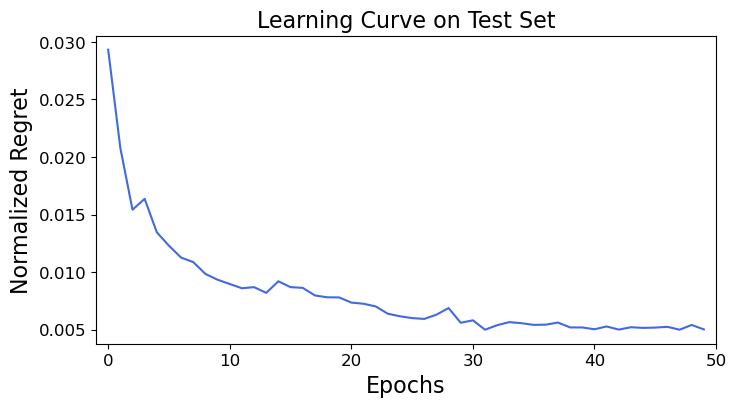

Test set:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.56s/it]


Avg Regret: 0.1572
Avg Rel Regret: 0.64%
Path Accuracy: 97.26%
Optimality Ratio: 83.30%


In [34]:
# plot
plotLearningCurve(loss_log3, regret_log3)
# eval
print("Test set:")
df3 = evaluate(nnet, optmodel, loader_test)

## DBB 

DBB model: training with differentiable black-box optimizer and MSE of solutions

In [35]:
# init net
nnet = partialResNet(k=12)
# cuda
if torch.cuda.is_available():
    nnet = nnet.cuda()
# set optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=lr)
# set stopper
#stopper = earlyStopper(patience=7)

In [36]:
# init dbb
dbb = pyepo.func.blackboxOpt(optmodel, lambd=20, processes=1) 
# set loss
class hammingLoss(torch.nn.Module):
    def forward(self, wp, w):
        loss = wp * (1.0 - w) + (1.0 - wp) * w
        return loss.mean(dim=0).sum()
hmloss = hammingLoss()

Num of cores: 1


In [37]:
# train
nnet.train()
loss_log4, regret_log4 = [], []
tbar = tqdm(range(epochs))
for epoch in tbar:
    for x, c, w, z in loader_train:
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = nnet(x) # predicted cost
        wp = dbb(cp) # black-box optimizer
        loss = hmloss(wp, w) # loss
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log4.append(loss.item())
        tbar.set_description("Epoch: {:2}, Loss: {:3.4f}".format(epoch, loss.item()))
    # scheduled learning rate
    if (epoch == int(epochs*0.6)) or (epoch == int(epochs*0.8)):
        for g in optimizer.param_groups:
            g['lr'] /= 10
    if epoch % log_step == 0:
        # log regret
        regret = pyepo.metric.regret(nnet, optmodel, loader_test) # regret on test
        regret_log4.append(regret)
        # early stop
        #regret = pyepo.metric.regret(nnet, optmodel, loader_val) # regret on val
        #if stopper.stop(regret):
        #    break

Epoch: 49, Loss: 30.9167: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [6:49:56<00:00, 491.92s/it]


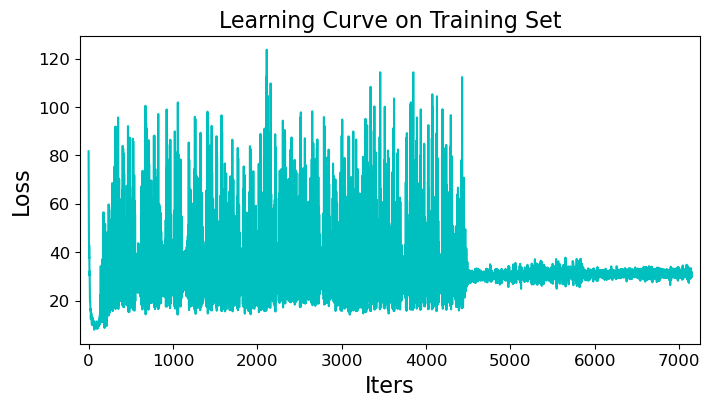

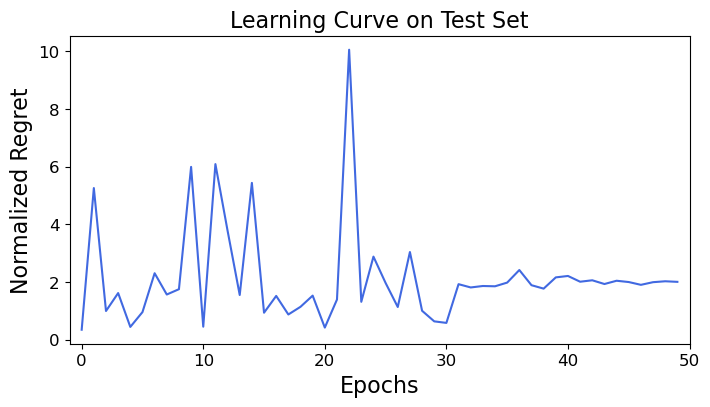

Test set:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.57s/it]


Avg Regret: 59.2715
Avg Rel Regret: 233.11%
Path Accuracy: 78.14%
Optimality Ratio: 0.00%


In [38]:
# plot
plotLearningCurve(loss_log4, regret_log4)
# eval
print("Test set:")
df4 = evaluate(nnet, optmodel, loader_test)

## DPO 

DPO model: training with differentiable perturbed optimizer and MSE of solutions

In [39]:
# init net
nnet = partialResNet(k=12)
# cuda
if torch.cuda.is_available():
    nnet = nnet.cuda()
# set optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=lr)
# set stopper
#stopper = earlyStopper(patience=7)

In [40]:
# init dbb
ptb = pyepo.func.perturbedOpt(optmodel, n_samples=1, epsilon=1.0, processes=1)
# set loss
mseloss = nn.MSELoss()

Num of cores: 1


In [41]:
# train
nnet.train()
loss_log5, regret_log5 = [], []
tbar = tqdm(range(epochs))
for epoch in tbar:
    for x, c, w, z in loader_train:
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = nnet(x) # predicted cost
        we = ptb(cp) # perturbed optimizer
        loss = mseloss(we, w) # loss
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log5.append(loss.item())
        tbar.set_description("Epoch: {:2}, Loss: {:3.4f}".format(epoch, loss.item()))
    # scheduled learning rate
    if (epoch == int(epochs*0.6)) or (epoch == int(epochs*0.8)):
        for g in optimizer.param_groups:
            g['lr'] /= 10
    if epoch % log_step == 0:
        # log regret
        regret = pyepo.metric.regret(nnet, optmodel, loader_test) # regret on test
        regret_log5.append(regret)
        # early stop
        #regret = pyepo.metric.regret(nnet, optmodel, loader_val) # regret on val
        #if stopper.stop(regret):
        #    break

Epoch: 49, Loss: 0.1141: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [3:36:59<00:00, 260.39s/it]


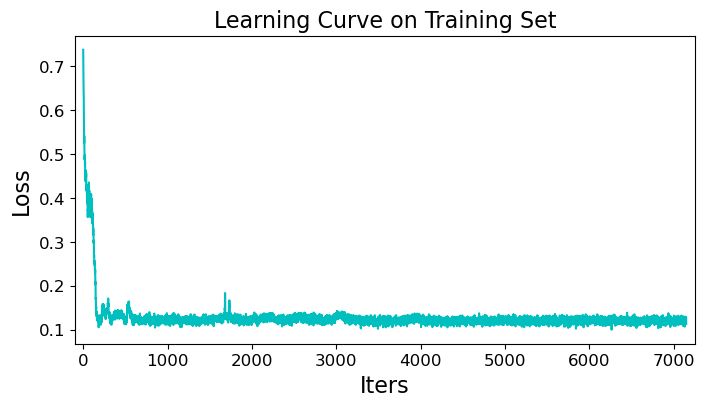

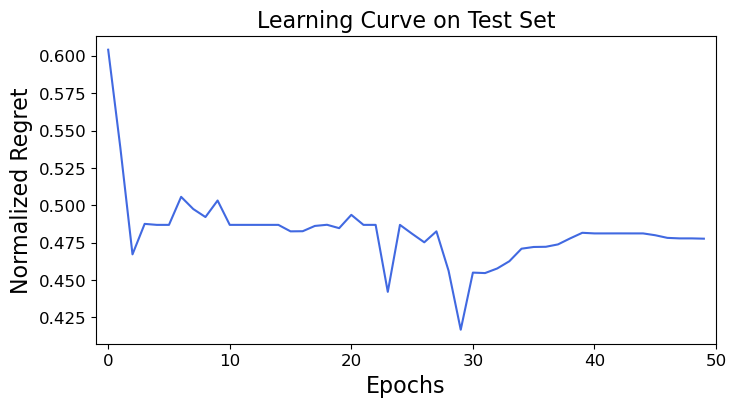

Test set:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.58s/it]


Avg Regret: 14.1869
Avg Rel Regret: 60.90%
Path Accuracy: 87.89%
Optimality Ratio: 4.90%


In [42]:
# plot
plotLearningCurve(loss_log5, regret_log5)
# eval
print("Test set:")
df5 = evaluate(nnet, optmodel, loader_test)

## PFYL

PFYL model: training with Perturbed Fenchel-Young loss

In [43]:
# init net
nnet = partialResNet(k=12)
# cuda
if torch.cuda.is_available():
    nnet = nnet.cuda()
# set optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=lr)
# set stopper
#stopper = earlyStopper(patience=7)

In [44]:
# set loss
fyloss = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=1, epsilon=1.0, processes=1)

Num of cores: 1


In [ ]:
# train
nnet.train()
loss_log6, regret_log6 = [], []
tbar = tqdm(range(epochs))
for epoch in tbar:
    for x, c, w, z in loader_train:
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = nnet(x) # predicted cost
        loss = fyloss(cp, w).mean() # loss
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log6.append(loss.item())
        tbar.set_description("Epoch: {:2}, Loss: {:3.4f}".format(epoch, loss.item()))
    # scheduled learning rate
    if (epoch == int(epochs*0.6)) or (epoch == int(epochs*0.8)):
        for g in optimizer.param_groups:
            g['lr'] /= 10
    if epoch % log_step == 0:
        # log regret
        regret = pyepo.metric.regret(nnet, optmodel, loader_test) # regret on test
        regret_log6.append(regret)
        # early stop
        #regret = pyepo.metric.regret(nnet, optmodel, loader_val) # regret on val
        #if stopper.stop(regret):
        #    break

Epoch: 45, Loss: 2.5000:  90%|███████████████████████████████████████████████████████████████▉       | 45/50 [3:19:30<22:04, 264.83s/it]

In [ ]:
# plot
plotLearningCurve(loss_log6, regret_log6)
# eval
print("Test set:")
df6 = evaluate(nnet, optmodel, loader_test)

## Comparison 

In [ ]:
# draw boxplot of regret per instance
fig = plt.figure(figsize=(16,6))
boxplot_data = [df1["Regret"], df3["Regret"], df4["Regret"], df5["Regret"], df6["Regret"]]
colors = ["#5aa461", "#77aadd", "#ee8866", "#9970ab", "#dd604d"]
bp = plt.boxplot(boxplot_data, medianprops=dict(color="w", linewidth=2), patch_artist=True, widths=0.75)
for i, patch in enumerate(bp["boxes"]):
    patch.set_facecolor(colors[i])
    patch.set_color(colors[i])
for i, patch in enumerate(bp["whiskers"]):
    patch.set_color(colors[i//2])
    patch.set_linewidth(2)
for i, patch in enumerate(bp["caps"]):
    patch.set_color(colors[i//2])
    patch.set_linewidth(2)
for i, patch in enumerate(bp["fliers"]):
    patch.set_marker("o")
    patch.set_markeredgecolor(colors[i])
    patch.set_markersize(6)
    patch.set_markeredgewidth(2)
# grid
plt.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
# labels and ticks
plt.xticks(ticks=range(1,6), fontsize=18, labels=["2S", "SPO+", "DBB", "DPO", "PFYL"])
plt.ylabel("Regret", fontsize=24)
plt.yticks(fontsize=12)
plt.xlim(0.5, 5.5)
#plt.ylim(-0.2, 15)
plt.title("Regret of each instance for Test Set", fontsize=24)
plt.show()

In [ ]:
# drow learning curve on test set
fig = plt.figure(figsize=(16,6))
colors = ["#5aa461", "#77aadd", "#ee8866", "#9970ab", "#dd604d"]
plt.plot([i*log_step for i in range(len(regret_log1))], regret_log1, color=colors[0], lw=3, ls="-", label="2S")
plt.plot([i*log_step for i in range(len(regret_log3))], regret_log3, color=colors[1], lw=3, ls="--", label="SPO+", )
plt.plot([i*log_step for i in range(len(regret_log4))], regret_log4, color=colors[2], lw=3, ls="-.", label="DBB")
plt.plot([i*log_step for i in range(len(regret_log5))], regret_log5, color=colors[3], lw=3, ls=":", label="DPO")
plt.plot([i*log_step for i in range(len(regret_log6))], regret_log6, color=colors[4], lw=3, ls=(0,(3,1,1,1,1,1)), label="PFYL")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-10, epochs)
#plt.ylim(-0.05, 0.895)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Normalized Regret", fontsize=16)
plt.title("Learning Curve on Test Set", fontsize=16)
plt.legend(fontsize=12)
plt.show()